# CDE Hyperparameter Tuning with Optuna

In this notebook, we will use Optuna to tune the hyperparameters of a 
conditional density estimator (CDE). [Optuna](https://optuna.org/) is a 
framework-agnostic hyperparameter tuning package. Given a range of 
hyperparameters, it traverses this space in a smart way, exploring parameter
values that are more likely to maximize/minimize your objective. 

In this notebook, we will also take advantage of an early-stopping protocol, 
where Optuna looks at the validation loss at each epoch of network training and
stops the trial if it is unlikely to beat the best set of hyperparameters
found so far.

Before starting, please make sure you have `keras` and `optuna` installed
in your environment.
<!--- TODO: figure out what the requirement versions are --> 

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split


import visual_bars.generate_visual_bars_data as vbd
from cfl.experiment import Experiment

import optuna
from optuna.integration import TFKerasPruningCallback
from optuna.trial import TrialState

from keras import Sequential
from keras.layers import Dense, Dropout
# TODO: install keras in requirements or instructions here

Using TensorFlow backend.


## Load Data
We will be using the visual bars example data for this tutorial. To learn 
more about this included dataset, please refer to the visual bars background
[page](https://cfl.readthedocs.io/en/latest/more_info/Visual_Bars_data.html).
If you would like to see a standard example of running CFL on this dataset
without hyperparameter tuning, please refer to the main CFL code 
[tutorial](https://cfl.readthedocs.io/en/latest/examples/cfl_code_intro.html).

Here, we create a dataset of 10000 samples, where the cause is a 10x10 image
and the effect is a binary 1D variable. For sake of simplicity, we will be
tuning a standard feed-forward network (as opposed to a convolutional 
neural network), so flatten the images down to vectors of shape (1,100). 

Since we want to evaluate our models on the same subset of the data across
all hyperparameter combinations, we generate in-sample and out-of-sample
indices to pass to CFL. If these are not provided, CFL generates this
split randomly, and it would look different across every trial. 

In [2]:
# create visual bars data 
n_samples = 20000 
im_shape = (10, 10) 
noise_lvl= 0.03
random_state = 180

vb_data = vbd.VisualBarsData(n_samples=n_samples, im_shape=im_shape, 
                             noise_lvl=noise_lvl, set_random_seed=random_state)

# retrieve the images and the target 
X = vb_data.getImages()
X = np.reshape(X, (X.shape[0], np.product(X.shape[1:]))) # flatten images
Y = vb_data.getTarget()
Y = np.expand_dims(Y, -1)
print(X.shape)
print(Y.shape)

# define train and validation sets to remain constant across tuning
in_sample_idx, out_sample_idx = train_test_split(np.arange(X.shape[0]),
                                                 train_size=0.75,
                                                 random_state=42)

(20000, 100)
(20000, 1)


## Make a CDE network

Next, we need to outline the architecture of our neural network. We use
Optuna's `trial.suggest_xxx` methods to determine the number of layers, number
of units in each layer, and the amount of dropout after each layer in the
network. For more information on how to use Optuna to suggest hyperparameters,
please refer to their [documentation](https://optuna.org/).

In [3]:
def build_model(trial):
    
    # vary number of layers
    n_layers = trial.suggest_int("n_layers", 1, 5)
    model = Sequential()
    
    for i in range(n_layers):
        # vary size of each layer
        num_hidden = trial.suggest_int("n_units_l{}".format(i), 4, 512, log=True)
        model.add(Dense(num_hidden, activation="relu"))

        # vary amount of dropout for each layer
        dropout = trial.suggest_float("dropout_l{}".format(i), 0.0, 0.5)
        model.add(Dropout(rate=dropout))

    # add output layer with size of target    
    model.add(Dense(Y.shape[1], activation="linear"))

    return model

## Define the tuning objective

Optuna takes in an `objective` function to perform tuning over. An objective
function should, assuming some set of hyperparameters generated by the
current optuna trial, 1) build our model of interest, 2) run the model, and
3) evaluate the model and return some metric of how well it did.

Here, we define the parameters for a CFL Experiment that contains one Block - 
a CDE. Specifically, we use a 'CondExpDIY' CDE because 1) we want to estimate
the conditional expectation of P(Y|X) instead of the full distribution for
computational esse, and 2) we want to provide our own model (defined above) 
instead of using a pre-defined model that CFL supplies.

Note that some of the parameters in `CDE_params` ('lr' and 'batch_size') are 
also defined by Optuna `trial.suggest_xxx` methods and will be optimized in
the same way as the network architecutre parameters.

Lastly, once the CDE has been trained, we pull the final validation loss
from the packaged cfl results and return it as our evaluation of the current
set of hyperparameters.

In [4]:
def objective(trial):

    # define the parameters for a CFL Experiment
    data_info = {'X_dims': X.shape, 'Y_dims': Y.shape, 'Y_type': 'categorical'}

    CDE_params = {
        'model'           : 'CondExpDIY',
        'optuna_callback' : TFKerasPruningCallback(trial, "val_loss"),
        'optuna_trial'    : trial,
        'build_model'     : build_model,

        'lr'              : trial.suggest_float("lr", 1e-5, 1e-1, log=True),                
        'batch_size'      : trial.suggest_int("batch_size", 16, 128),
        'n_epochs'        : 100,
        'optimizer'       : 'adam',
        'loss'            : 'mean_squared_error',
        'best'            : True, 
        'verbose'         : 0,
        'early_stopping'  : True,
    }

    block_names = ['CondDensityEstimator']
    block_params = [CDE_params]

    my_exp = Experiment(X_train=X, 
                        Y_train=Y, 
                        in_sample_idx=in_sample_idx,
                        out_sample_idx=out_sample_idx,
                        data_info=data_info, 
                        block_names=block_names, 
                        block_params=block_params, 
                        verbose=0,
                        results_path=None) # we don't want to save 100's of results

    train_results = my_exp.train()     
    score = train_results['CondDensityEstimator']['val_loss'][-1]
    return score

## Run an Optuna study

Finally, we are ready to optimize our hyperparameters. We first create
a 'study' which will minimize the score returned by `objective` above, and
will prune training during trials where the validation loss isn't dropping
at a promising rate.

We call `study.optimize` to try 50 different samples of hyperparameters from
the space we described with the `trial.suggest_xxx` methods.

By setting `show_plot` to `True` in `CDE_params`, we can visualize how the 
loss varies across different hyperparameter combinations.

In [5]:
study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=150)

[I 2022-02-07 11:59:13,353] A new study created in memory with name: no-name-7b2c54ef-7373-48af-ab11-98379a025dd6


## Print out `study` statistics and optimal hyperparameters found

In [ ]:
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  150
  Number of pruned trials:  123
  Number of complete trials:  27
Best trial:
  Value:  0.1389396020397544
  Params: 
    lr: 0.00015324890591370544
    batch_size: 121
    n_layers: 1
    n_units_l0: 142
    dropout_l0: 0.12469200035098352


## Rerun CFL with the optimized hyperparameters

Now, we run CFL with a CDE that is parameterized by the optimal hyperparameters 
printed out in the previous cell, and a CauseClusterer that uses the
expected conditional probability estimated in the previous step to construct
macrovariable states.

save_path 'demo_results' doesn't exist, creating now.
All results from this run will be saved to demo_results/experiment0000
#################### Beginning CFL Experiment training. ####################
Beginning CDE training...


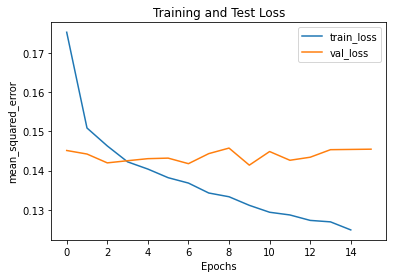

CDE training complete.
Beginning CauseClusterer training...
CauseClusterer training complete.
Experiment training complete.


In [ ]:
# so our optimized model becomes:

def build_optimized_model():

    # vary number of layers
    n_layers = study.best_trial.params['n_layers']
    model = Sequential()
    for i in range(n_layers):
        # vary size of each layer
        num_hidden = study.best_trial.params[f'n_units_l{i}']
        model.add(Dense(num_hidden, activation="relu"))

        # vary amount of dropout for each layer
        dropout = study.best_trial.params[f'dropout_l{i}']
        model.add(Dropout(rate=dropout))

    # add output layer with size of target    
    model.add(Dense(Y.shape[1], activation="linear"))
    return model

data_info = {'X_dims': X.shape, 'Y_dims': Y.shape, 'Y_type': 'categorical'}

CDE_params = {
    'model'           : 'CondExpDIY',
    'build_model'     : build_optimized_model,

    'lr'              : study.best_trial.params['lr'],                
    'batch_size'      : study.best_trial.params['batch_size'],
    'n_epochs'        : 100,
    'optimizer'       : 'adam',
    'loss'            : 'mean_squared_error',
    'best'            : True, 
    'verbose'         : 0,
    'early_stopping'  : True
}

cause_cluster_params = {'model' : 'KMeans', 'n_clusters' : 4, 'verbose' : 0}

block_names = ['CondDensityEstimator', 'CauseClusterer']
block_params = [CDE_params, cause_cluster_params]

my_exp = Experiment(X_train=X, Y_train=Y, data_info=data_info, 
                    in_sample_idx=in_sample_idx, out_sample_idx=out_sample_idx,
                    block_names=block_names, block_params=block_params, 
                    results_path='demo_results')

train_results = my_exp.train()     

## Visualize the conditional probability learned by CFL with the optimized hyperparameters

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='Sample', ylabel='Expectation of Target'>)

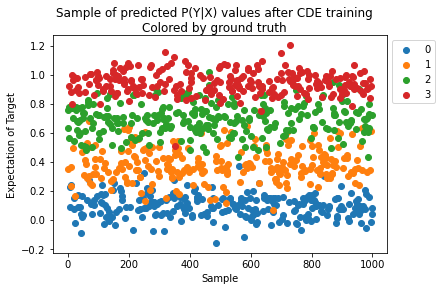

In [ ]:
from cfl.visualization.cde_diagnostic import pyx_scatter
pyx_scatter(my_exp, vb_data.getGroundTruth())

## Visualize the macrovariable states that CFL finds with this set of hyperparameters

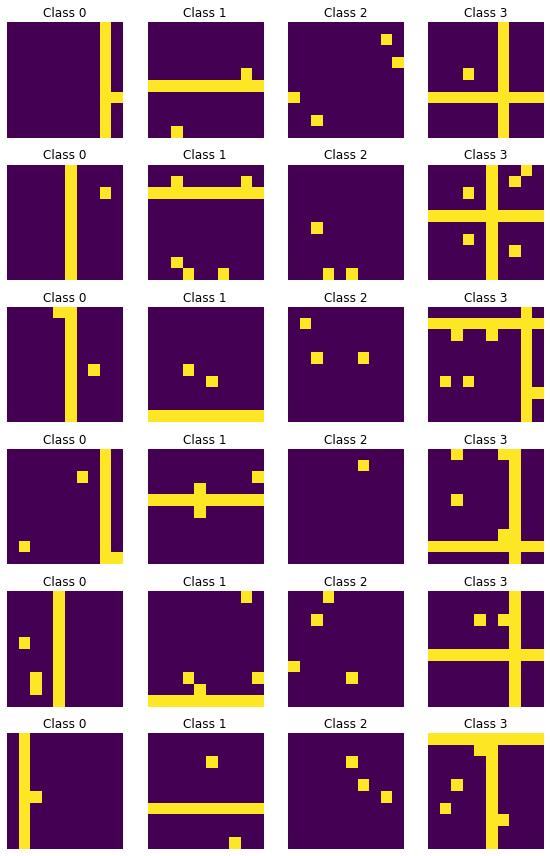

In [ ]:
import visual_bars.visual_bars_vis as vis

vis.viewImagesAndLabels(X, im_shape=im_shape, n_examples=6, 
                        x_lbls=train_results['CauseClusterer']['x_lbls'])